# Bayesian Workflow Example (Strack RRR Analysis Replication)

In [1]:
# Author: tyarkoni, jake-westfall 
# Created At: Mar 15, 2017
# Last Run: Mar 27, 2019

In this Jupyter notebook, we do a Bayesian reanalysis of the data reported in the [recent registered replication report](http://www.psychologicalscience.org/pdf/StrackRRR_manuscript_accepted.pdf) (RRR) of a famous study by Strack, Martin & Stepper (1988). The original Strack et al. study tested a *facial feedback hypothesis* arguing that emotional responses are, in part, driven by facial expressions (rather than expressions always following from emotions). Strack and colleagues reported that participants rated cartoons as more funny when the participants held a pen in their teeth (unknowingly inducing a smile) than when they held a pen between their lips (unknowingly inducing a pout). The article has been cited over 1,400 times, and has been enormously influential in popularizing the view that affective experiences and outward expressions of affective experiences can both influence each other (instead of the relationship being a one-way street from experience to expression). In 2016, a Registered Replication Report led by Wagenmakers and colleagues attempted to replicate Study 1 from Strack, Martin, & Stepper (1988) in 17 independent experiments comprising over 2,500 participants. The RRR reported no evidence in support of the effect.

Here we use the [Bambi](http://github.com/bambinos/bambi) model-building interface (itself just a wrapper for [PyMC3](http://github.com/pymc-devs/pymc3) and [Stan](http://mc-stan.org)) to quickly re-analyze the RRR data using a Bayesian approach. Because the emphasis here is on fitting models in Bambi, we spend very little time on quality control and data exploration; our goal is simply to show how one can replicate and extend the primary analysis reported in the RRR in a few lines of Bambi code.

We begin by importing all of the modules we'll need, and enabling inline plotting with matplotlib.

In [2]:
from glob import glob
import pandas as pd
import bambi as bmb
from os.path import basename
import arviz as az

In [3]:
az.style.use('arviz-darkgrid')

## Reading in the data
The data for the RRR of Strack, Martin, & Stepper (henceforth *SMS*) is available as [a set of CSV files](???) from the project's repository on the Open Science Framework. For the sake of completeness, we'll show how to go from the raw CSV to the "long" data format that Bambi can use (and that's required by most other mixed-effects modeling packages).

One slightly annoying thing about these 17 CSV files--each of which represents a different replication site--is that they don't all contain exactly the same columns. Some labs added a column or two at the end (mostly for notes). To keep things simple, we'll just truncate each dataset to only the first 22 columns. Because the variable names are structured in a bit of a confusing way, we'll also just drop the first two rows in each file, and manually set the column names for all 22 variables. Once we've done that, we can simply concatenate all of the 17 datasets along the row axis to create one big dataset.

In [4]:
DL_PATH = 'data/facial_feedback/*csv'

dfs = []
columns = ['subject', 'cond_id', 'condition', 'correct_c1', 'correct_c2', 'correct_c3', 'correct_c4',
           'correct_total', 'rating_t1', 'rating_t2', 'rating_c1', 'rating_c2', 'rating_c3',
           'rating_c4', 'self_perf', 'comprehension', 'awareness', 'transcript', 'age', 'gender',
           'student', 'occupation']

for study in glob(DL_PATH):
    data = pd.read_csv(study, encoding='latin1', skiprows=2, header=None, index_col=False).iloc[:, :22]
    data.columns = columns
    # Add study name
    data['study'] = basename(study).split('_')[0]
    # Some sites used the same subject id numbering schemes, so prepend with study to create unique ids.
    # Note that if we don't do this, Bambi would have no way of distinguishing two subjects who share
    # the same id, which would hose our results.
    data['uid'] = data['subject'].astype(str) + '_' + data['study']
    dfs.append(data)
data = pd.concat(dfs, axis=0).convert_objects(convert_numeric=True)

/home/osvaldo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Let's see what the first few rows look like...

In [5]:
data.head()

,subject,cond_id,condition,correct_c1,correct_c2,correct_c3,correct_c4,correct_total,rating_t1,rating_t2,...,self_perf,comprehension,awareness,transcript,age,gender,student,occupation,study,uid
0,1.0,39814.0,1.0,1.0,1.0,1.0,1.0,4.0,6.0,3.0,...,NaN,1.0,0.0,To see if people follow directions,19.0,0.0,1.0,NaN,Wayand,1.0_Wayand
1,2.0,39829.0,0.0,1.0,1.0,1.0,1.0,4.0,8.0,6.0,...,NaN,1.0,0.0,I think the point of the study was to determin...,19.0,1.0,1.0,NaN,Wayand,2.0_Wayand
2,3.0,39817.0,1.0,1.0,0.0,1.0,1.0,3.0,7.0,5.0,...,NaN,1.0,0.0,To see how accuratly and quickly simple tasks ...,20.0,0.0,1.0,NaN,Wayand,3.0_Wayand
3,4.0,39994.0,0.0,1.0,0.0,1.0,1.0,3.0,5.0,3.0,...,NaN,1.0,0.0,If using different body parts for tasks not no...,20.0,0.0,1.0,NaN,Wayand,4.0_Wayand
4,5.0,39541.0,1.0,1.0,1.0,1.0,1.0,4.0,7.0,4.0,...,NaN,1.0,0.0,Seeing what effecting holding the pen in the m...,18.0,0.0,1.0,NaN,Wayand,5.0_Wayand


## Reshaping the data
At this point we have our data in a pandas DataFrame with shape of (2612, 24). Unfortunately, we can't use the data in this form. We'll need to (a) conduct some basic quality control, and (b) "melt" the dataset--currently in so-called "wide" format, with each subject in a separate row--into long format, where each row is a single trial. Fortunately, we can do this easily in pandas:

In [6]:
# Keep only subjects who (i) respond appropriately on all trials,
# (ii) understand the cartoons, and (iii) don't report any awareness
# of the hypothesis or underlying theory.
valid = data.query('correct_total==4 and comprehension==1 and awareness==0')
long = pd.melt(valid, ['uid', 'condition', 'gender', 'age', 'study', 'self_perf'],
               ['rating_c1', 'rating_c2', 'rating_c3', 'rating_c4'], var_name='stimulus')

Notice that in the `melt()` call above, we're treating not only the unique subject ID (uid) as an identifying variable, but also gender, experimental condition, age, and study name. Since these are all between-subject variables, these columns are all completely redundant with `uid`, and adding them does nothing to change the structure of our data. The point of explicitly listing them is just to keep them around in the dataset, so that we can easily add them to our models.

## Fitting the model
Now that we're all done with our (minimal) preprocessing, it's time to fit the model! This turns out to be a snap in Bambi. We'll begin with a very naive (and, as we'll see later,  incorrect) model that includes only the following terms:

* An overall (fixed) intercept.
* The fixed effect of experimental condition ("smiling" by holding a pen in one's teeth vs. "pouting" by holding a pen in one's lips). This is the primary variable of interest in the study.
* A random intercept for each of the 1,728 subjects in the 'long' dataset. (There were 2,576 subjects in the original dataset, but about 25% were excluded for various reasons, and we're further excluding all subjects who lack complete data. As an exercise, you can try relaxing some of these criteria and re-fitting the models, though you'll probably find that it makes no meaningful difference to the results.)

We'll create a Bambi model, fit it, and store the results in a new object--which we can then interrogate in various ways.

In [7]:
# Initialize the model, passing in the dataset we want to use.

model = bmb.Model(long, dropna=True)
model.add('value ~ condition', random=['1|uid'])

# Set a custom prior on random factor variances—just for illustration
random_sd = bmb.Prior('Uniform', lower=0, upper=10)
random_prior = bmb.Prior('Normal', mu=0, sd=random_sd)
model.set_priors(random=random_prior)

# Fit the model, drawing 2,000 MCMC samples
results = model.fit(samples=1000, backend='pymc')

/home/osvaldo/proyectos/00_PyMC3/bambi/bambi/models.py:148: UserWarning: Automatically removing 9/6940 rows from the dataset.
  warnings.warn(msg)
/home/osvaldo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [value_sd, 1|uid_offset, 1|uid_sd, condition, Intercept]
INFO:pymc3:NUTS: [value_sd, 1|uid_offset, 1|uid_sd, condition, Intercept]
100%|██████████| 1500/1500 [00:47<00:00, 87.30it/s]


Notice that, in Bambi, the fixed and random effects are specified separately (for technical reasons we won't get into here). The fixed effects can be specified using R-style formulas. The underlying parsing of the formula is done by [patsy](https://github.com/pydata/patsy), and you can find out much more about the operators patsy supports by reading its excellent [documentation](http://patsy.readthedocs.io/en/latest/formulas.html). The random effects are specified as a list, where each term is a separate element. In this case, we only have one random factor (unique subject id) to include.

When we run the above code, nothing much will happen for a while. The process of compiling the model in Theano (the numerical library that PyMC3--and hence, Bambi--relies on) can take a few minutes (on newer versions of Bambi, you can also opt to use a Stan back-end that is often faster to compile and sample). Once sampling starts, we get a nice progress bar (courtesy of PyMC3) that keeps us updated on the sampler's progress. Our model is fairly large, in that it includes nearly 1800 parameters (most of which are the random subject intercepts); even so, it should take only a few minutes to run on newer machines.

## Inspecting results
We can plot the posterior distributions and traces for all parameters with the `plot()` method.

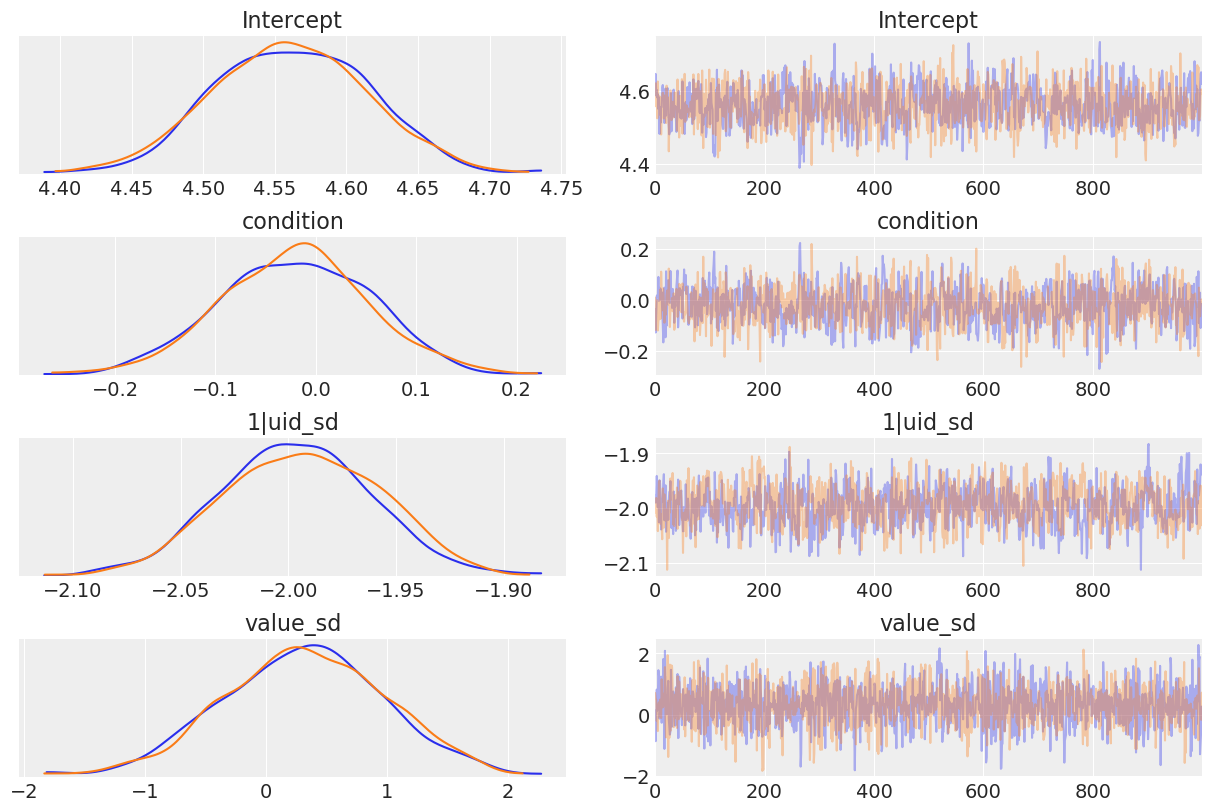

In [8]:
results.plot(var_names=['Intercept', 'condition', 'value_sd', '1|uid_sd']);

If we want a numerical summary of the results, we can call the results object's `summary()` method (again simply a wrapper for PyMC3's method of the same name). By default, the summary display shows us the mean, standard deviation, and 95% highest posterior density interval.

In [9]:
# Show summary statistics for all fixed effects and variances;
results.summary()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,4.561,0.054,4.466,4.664,0.002,0.001,1134.0,1134.0,1136.0,1210.0,1.0
condition,-0.021,0.074,-0.147,0.130,0.002,0.002,1098.0,1098.0,1101.0,1316.0,1.0
1|uid_sd,-1.995,0.035,-2.059,-1.929,0.001,0.001,675.0,675.0,674.0,860.0,1.0
value_sd,0.310,0.674,-0.890,1.645,0.014,0.016,2431.0,870.0,2430.0,1145.0,1.0


## Expanding the model
Looking at the parameter estimates produced by our model, it seems pretty clear that there's no meaningful effect of condition. The posterior distribution is centered almost exactly on 0, with most of the probability mass on very small values. The 95% HPD spans from -0.16 to -0.16--in other words, the plausible effect of the experimental manipulation is, at best, to produce a change of < 0.2 on cartoon ratings made on a 10-point scale. For perspective, the variation between subjects is enormous in comparison--the standard deviation `u_uid` is around 1.2. We can also see that the model is behaving well, and the sampler seems to have converged nicely (the traces for all parameters look stationary).

Unfortunately, our first model has at least two pretty serious problems. First, it gives no consideration to between-study variation--we're simply lumping all 1,728 subjects together, as if they came from the same study. A better model would properly account for study-level variation. We could model study as either a fixed or a random factor in this case--both choices are defensible, depending on whether we want to think of the 17 studies in this dataset as the only sites of interest, or as if they're just 17 random sites drawn from some much larger population. For present purposes, we'll adopt the latter strategy (as an exercise, you can modify the the code below and re-run the model with study as a fixed factor). We'll ["keep it maximal"](http://idiom.ucsd.edu/~rlevy/papers/barr-etal-2013-jml.pdf) by adding both random study intercepts and random study slopes to the model. That is, we'll assume that the subjects at each research site have a different baseline appreciation of the cartoons (some find the cartoons funnier than others), and that the effect of condition also varies across sites.

Second, our model also fails to explicitly model variation in cartoon ratings that should properly be attributed to the 4 stimuli. In principle, our estimate of the fixed effect of condition could change somewhat once we correctly account for stimulus variability (though in practice, the net effect is almost always to *reduce* effects, not increase them--so in this case, it's very unlikely that adding random stimulus effects will produce a meaningful effect of condition). So we'll deal with this by adding random intercepts for the 4 stimuli. We'll model the stimuli as random rather than fixed, because it wouldn't make sense to think of these particular cartoons as exhausting the universe of stimuli we care about (i.e., we wouldn't really care about the facial-feedback effect if we knew that it only applied to 4 specific Far Side cartoons, and no other stimuli).

Lastly, just for fun, we can throw in some additional covariates, since they're readily available in the dataset, and may be of interest even if they don't directly inform the core hypothesis. Specifically, we'll add fixed effects of gender and age to the model, which will let us estimate the degree to which participants' ratings of the cartoons varies as a function of these background variables.

Once we've done all that, we end up with a model that's in a good position to answer the question we care about--namely, whether the smiling/pouting manipulation has an effect on cartoon ratings that generalizes across the subjects, studies, and stimuli found in the RRR dataset.

In [10]:
model = bmb.Model(long, dropna=True)
model.fit('value ~ 1 + condition + age + gender',
          random=['condition|study', '1|uid', 'condition|stimulus'],
          run=False)
random_sd = bmb.Prior('Uniform', lower=0, upper=10)
random_prior = bmb.Prior('Normal', mu=0, sd=random_sd)
model.set_priors(random=random_prior)
results = model.fit(samples=1000, backend='pymc')

/home/osvaldo/proyectos/00_PyMC3/bambi/bambi/models.py:148: UserWarning: Automatically removing 33/6940 rows from the dataset.
  warnings.warn(msg)
/home/osvaldo/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO:pymc3:Sequential sampling (2 chains in 1 job)
NUTS: [value_sd, condition|stimulus_offset, condition|stimulus_sd, 1|stimulus_offset, 1|stimulus_sd, 1|uid_offset, 1|uid_sd, condition|study_offset, condition|study_sd, 1|study_offset, 1|study_sd, gender, age, condition, Intercept]
INFO:pymc3:NUTS: [value_sd, condition|stimulus_offset, condition|stimulus_sd, 1|stimulus_offset, 1|stimulus_sd, 1|uid_offse

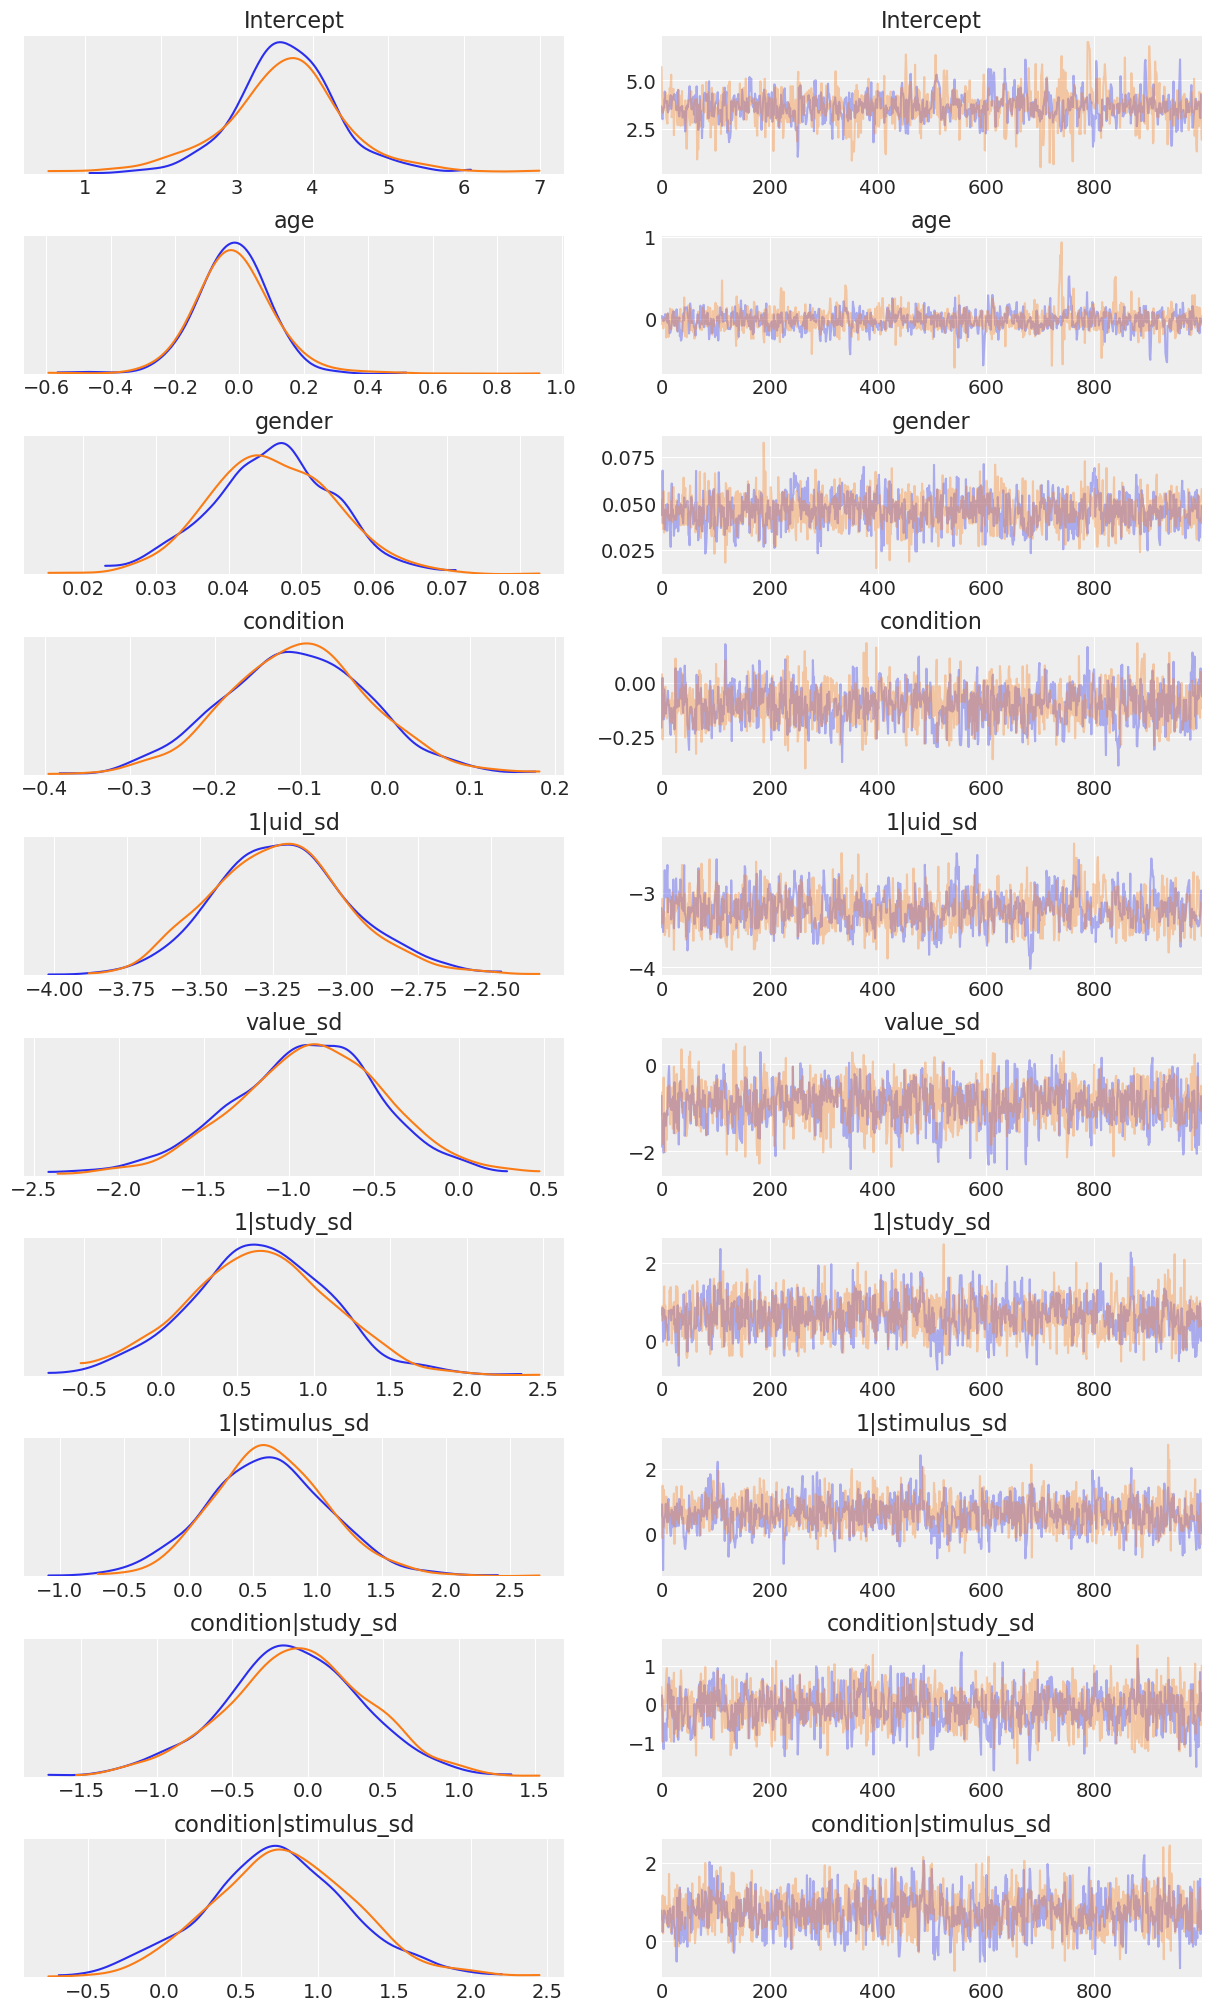

In [11]:
results.plot(var_names=['age', '1|stimulus_sd', 'condition|stimulus_sd', 'gender', 'condition|study',
                       '1|stimulus', 'value_sd', '1|iud_sd', 'Intercept', 'condition|study_sd',
                       '1|study', 'condition', 'condition|stimulus']);

## And the answer is...
No. There's still no discernible effect. Modeling the data using a mixed-effects model does highlight a number of other interesting features, however:
* The stimulus-level variance `u_stimulus_sd` is quite large compared to the other factors. This is potentially problematic, because it suggests that a more conventional analysis that left individual stimulus effects out of the model could potentially run a high false positive rate. Note that this is a problem that affects both the RRR and the original Strack study equally; the moral of the story is [to deliberately sample large numbers of stimuli and explicitly model their influence](http://jakewestfall.org/publications/crossed_power_JEPG.pdf).
* Older people seem to rate cartoons as being (a little bit) funnier.
* The variation across sites is surprisingly small--in terms of both the random intercepts (`u_study_id`) and the random slopes (`u_condition|study_id`). In other words, the constitution of the sample, the gender of the experimenter, or any of the hundreds of others of between-site differences that one might conceivably have expected to matter, don't really seem to make much of a difference to participants' ratings of the cartoons. 